# DATA 602 Final Project - Energy Price Predictions

Initial Draft: Connor Trask

In [68]:
#Import necessary modules

from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [43]:
#Get last 24 hours of price data from ComEd in 5 minute increments
#price_json = requests.get("https://hourlypricing.comed.com/api?type=5minutefeed")
#Get all price data from ComEd for 2023 in 5 minute increments (up to October 1st)
#Datetime format is YYYYMMDDhhmm
price_json = requests.get("https://hourlypricing.comed.com/api?type=5minutefeed&datestart=202301010100&dateend=202310012359")
price_df = pd.read_json(price_json.text)
#time is in millis UTC, price is cents/kWh
price_df.columns = ["time", "price"]
price_df.head()

,time,price
0,1696222500000,1.2
1,1696222200000,1.1
2,1696221900000,0.9
3,1696221600000,1.0
4,1696221300000,1.8


<Axes: xlabel='time', ylabel='price'>

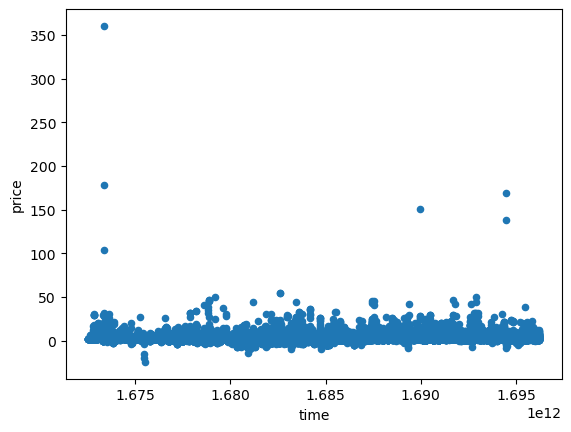

In [44]:
#Exploratory visualization
price_df.plot.scatter("time","price")

<Axes: >

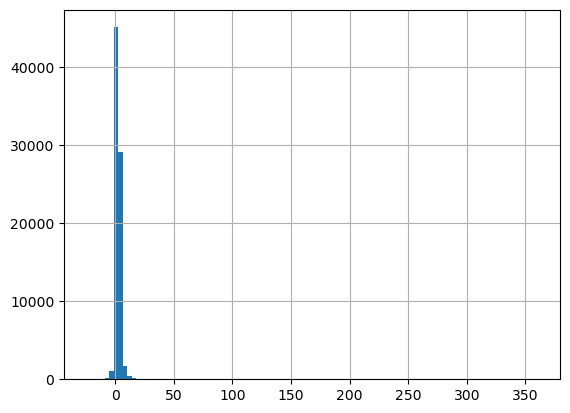

In [45]:
price_df["price"].hist(bins=100)

An exploratory analysis of the price data for 2023 reveals the presence of significant outliers, which make it difficult to observe any patterns in the data. A frequency analysis of the price data reveals that the vast majority of the data is between -10 and 20 cents per kilowatt-hour, so as a result we mask our data to remove any points outside of this range and repeat our visualizations.

<Axes: xlabel='time', ylabel='price'>

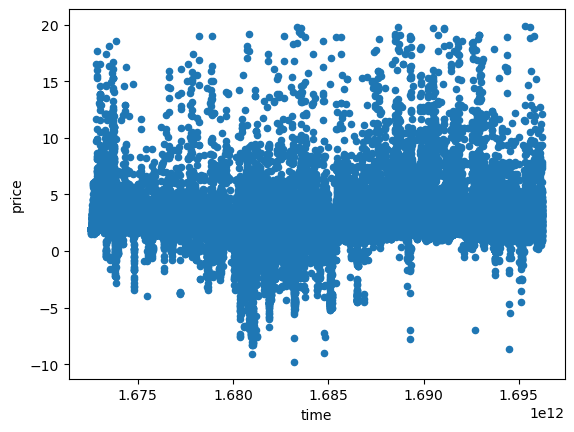

In [47]:
price_df = price_df[(price_df["price"] < 20) & (price_df["price"] > -10)]
price_df.plot.scatter("time","price")

Average price per kilowatt-hour: 2.5915


<Axes: >

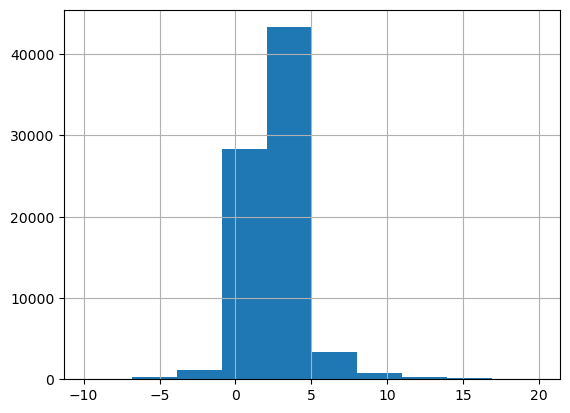

In [48]:
print("Average price per kilowatt-hour: {:.4f}".format(np.mean(price_df["price"])))
price_df["price"].hist()

With this filtered data, we can observe that the data is roughly normally distributed, with a mean of ~2.5 cents/kWh. On the timescale of a year, there is no apparent trend to the data, as price appears to be uniformly distributed over the year. The hope is that patterns will become more present as we reduce our timescale and add additional environmental data, converting our noisy price data into useful predictive data.

In [49]:
price_df["time"] = price_df["time"]/1000
price_df["datetime"] = price_df["time"].apply(datetime.datetime.fromtimestamp)
price_df.head()

,time,price,datetime
0,1.696222e+09,1.2,2023-10-02 00:55:00
1,1.696222e+09,1.1,2023-10-02 00:50:00
2,1.696222e+09,0.9,2023-10-02 00:45:00
3,1.696222e+09,1.0,2023-10-02 00:40:00
4,1.696221e+09,1.8,2023-10-02 00:35:00


In [50]:
price_df["datetime (str)"] = price_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
price_df[['date', 'time']] = price_df['datetime (str)'].str.split(' ', n=1, expand=True)
price_df.head()

,time,price,datetime,datetime (str),date
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02 00:55:00,2023-10-02
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02 00:50:00,2023-10-02
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02 00:45:00,2023-10-02
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02 00:40:00,2023-10-02
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02 00:35:00,2023-10-02


In [51]:
price_df[["year", "month", "day"]] = price_df["date"].str.split("-", n=2, expand=True)
price_df[["hour", "minute", "second"]] = price_df["time"].str.split(":", n=2, expand=True)
price_df.head()

,time,price,datetime,datetime (str),date,year,month,day,hour,minute,second
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02 00:55:00,2023-10-02,2023,10,02,00,55,00
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02 00:50:00,2023-10-02,2023,10,02,00,50,00
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02 00:45:00,2023-10-02,2023,10,02,00,45,00
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02 00:40:00,2023-10-02,2023,10,02,00,40,00
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02 00:35:00,2023-10-02,2023,10,02,00,35,00


In [52]:
#Year and second can both be dropped, since we are currently only looking at 2023 data and our resolution is only 5 minutes
price_df.drop(columns=["year", "second", "datetime (str)"], inplace=True)
price_df.head()

,time,price,datetime,date,month,day,hour,minute
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02,10,02,00,55
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02,10,02,00,50
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02,10,02,00,45
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02,10,02,00,40
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02,10,02,00,35


<Axes: xlabel='datetime', ylabel='price'>

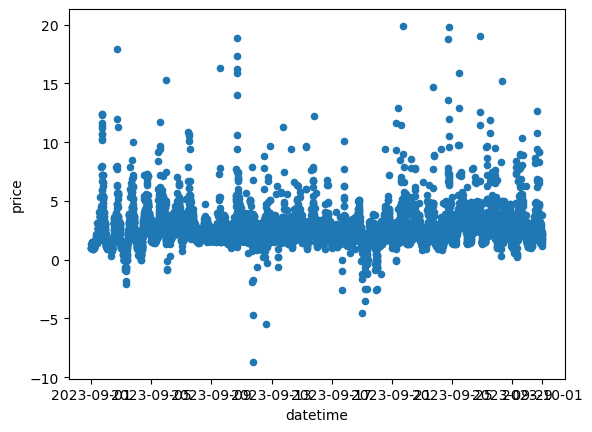

In [53]:
september_data = price_df[price_df["month"] == "09"]
september_data.plot.scatter("datetime","price")

<Axes: xlabel='datetime', ylabel='price'>

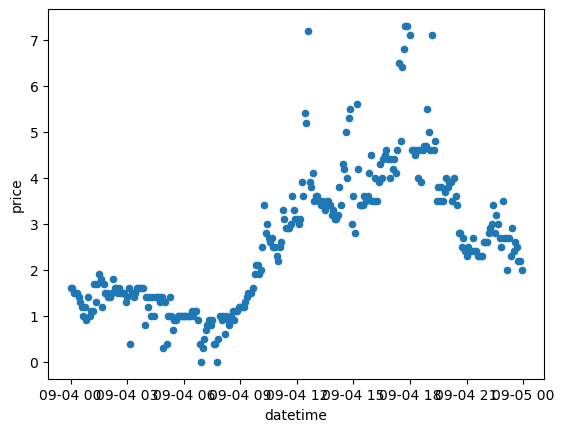

In [54]:
single_day = price_df[(price_df["month"] == "09") & (price_df["day"] == "04")]
single_day.plot.scatter("datetime", "price")

While there is no clear pattern in the price data at the year or month level, we can see a clear sinusoidal pattern emerge at the day scale. As expected, Energy prices are low late at night into the morning (approximately Midnight to 9 am), before increasing up to the daily peak (approximately noon to 6 pm), then declining back down in the evening. 

## Fitting Daily Model

<Axes: xlabel='decimal time', ylabel='price'>

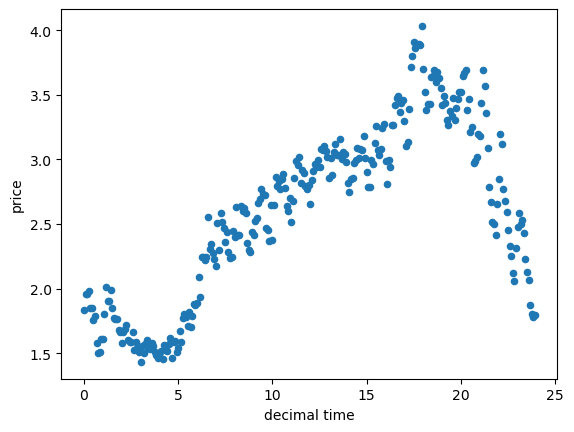

In [66]:
#Create decimal time column and groupby on it for curve fitting
price_df["decimal time"] = price_df["hour"].astype(int) + price_df["minute"].astype(float)/60
day_df = price_df.groupby(["decimal time"], as_index=False).mean()
day_df.plot.scatter("decimal time","price")

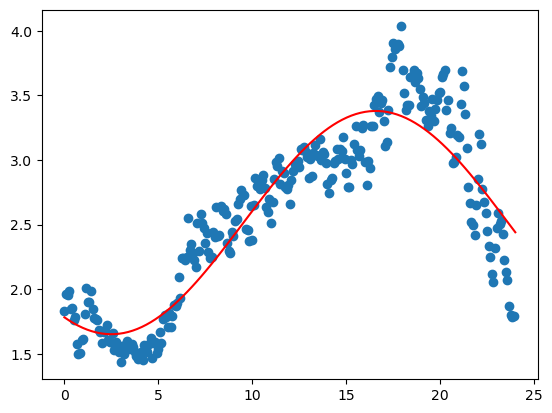

In [72]:
def sin(x,a,b,c,d):
    return a*np.sin(b*(x+c)) + d

cof, cov = sp.optimize.curve_fit(sin, day_df["decimal time"], day_df["price"], [-1.25,0.25,0,2.5])
x = np.linspace(0,24,100)
plt.plot(x, sin(x,*cof),"r")
plt.scatter(day_df["decimal time"], day_df["price"])